## Importing Libraries

In [1]:
import gym
import gym_anytrading
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from technicalindicators import TechnicalIndicators
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from gym_anytrading.envs import StocksEnv
import yfinance as yf
from datetime import datetime
from finta import TA

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\yaswa\anaconda3\envs\Stock\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


## Get Tesla stock Data

In [4]:
stock_name = 'TSLA'
today_dt = datetime.today().strftime('%Y-%m-%d')
df = yf.download(stock_name, start='2010-01-01', end=today_dt)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.sort_values('Date', ascending=True, inplace=True)

## Calculating Technical Indicators

In [6]:
df['SMA'] = TA.SMA(df, 14)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df['Stochastic_Oscillator'] = TA.STOCH(df)
df['CCI'] = TA.CCI(df)
df['ADX'] = TA.ADX(df)
df['DMI+'] = TA.DMI(df,14)['DI+']
df['DMI-'] = TA.DMI(df,14)['DI-']
df['Williams %R'] = TA.WILLIAMS(df)
df['VAMA'] = TA.VAMA(df,20)
df['HMA'] = TA.HMA(df,9)
df['CMO'] = TA.CMO(df)
df['MACD'] = TA.MACD(df)['MACD']
df['MACD_Signal'] = TA.MACD(df)['SIGNAL']
df['PPO'] = TA.PPO(df)['PPO']
df['PPO_Signal'] = TA.PPO(df)['SIGNAL']
df['PPO_HISTO'] = TA.PPO(df)['HISTO']
df['ROC'] = TA.ROC(df)
df['CHAIKIN'] = TA.CHAIKIN(df)
df['BULL_POWER'] = TA.EBBP(df)['Bull.']
df['BEAR_POWER'] = TA.EBBP(df)['Bear.']
df['BB_UPPER'] = TA.BBANDS(df)['BB_UPPER']
df['BB_MIDDLE'] = TA.BBANDS(df)['BB_MIDDLE']
df['BB_LOWER'] = TA.BBANDS(df)['BB_LOWER']

In [7]:
df = df.dropna(axis = 0)

## Adding Features to environment

In [8]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV','Stochastic_Oscillator','CCI','ADX','DMI+','DMI-','Williams %R','VAMA','HMA','CMO','MACD','MACD_Signal','PPO','PPO_Signal','PPO_HISTO','ROC','CHAIKIN','BULL_POWER','BEAR_POWER','BB_UPPER','BB_MIDDLE','BB_LOWER']].to_numpy()[start:end]
    return prices, signal_features

## Creating custom environment

In [9]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=60, frame_bound=(60,int(df.shape[0]*0.8)))

In [10]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

## Training the environment

In [11]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -457     |
| fps                | 27       |
| nupdates           | 1        |
| policy_entropy     | 0.691    |
| total_timesteps    | 5        |
| value_loss         | 0.00396  |
---------------------------------
---------------------------------
| explained_variance | -11.1    |
| fps                | 634      |
| nupdates           | 100      |
| policy_entropy     | 0.689    |
| total_timesteps    | 500      |
| value_loss         | 0.00409  |
---------------------------------
---------------------------------
| explained_variance | -0.00564 |
| fps                | 721     

In [12]:
env = MyCustomEnv(df=df, window_size=60, frame_bound=(int(df.shape[0]*0.8),df.shape[0]))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 464.1378707885742, 'total_profit': 1.8416254720768008, 'position': 1}


## Plotting results

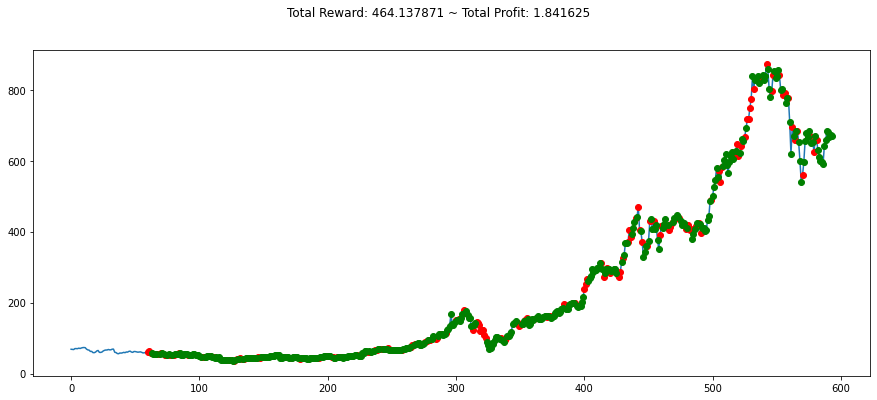

In [13]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## From the above figure we are able to make a profit of 84%